In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

In [2]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented')):
    subfolder_path = os.path.join('/kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


image             label
0      /kaggle/input/alzheimers-multiclass-dataset-eq...  ModerateDemented
1      /kaggle/input/alzheimers-multiclass-dataset-eq...  ModerateDemented
2      /kaggle/input/alzheimers-multiclass-dataset-eq...  ModerateDemented
3      /kaggle/input/alzheimers-multiclass-dataset-eq...  ModerateDemented
4      /kaggle/input/alzheimers-multiclass-dataset-eq...  ModerateDemented
...                                                  ...               ...
43995  /kaggle/input/alzheimers-multiclass-dataset-eq...      MildDemented
43996  /kaggle/input/alzheimers-multiclass-dataset-eq...      MildDemented
43997  /kaggle/input/alzheimers-multiclass-dataset-eq...      MildDemented
43998  /kaggle/input/alzheimers-multiclass-dataset-eq...      MildDemented
43999  /kaggle/input/alzheimers-multiclass-dataset-eq...      MildDemented

[44000 rows x 2 columns]

Exact counts for each class:
label
NonDemented         12800
VeryMildDemented    11200
ModerateDemented    10000
MildDemented        10000
Name: count, dtype: int64


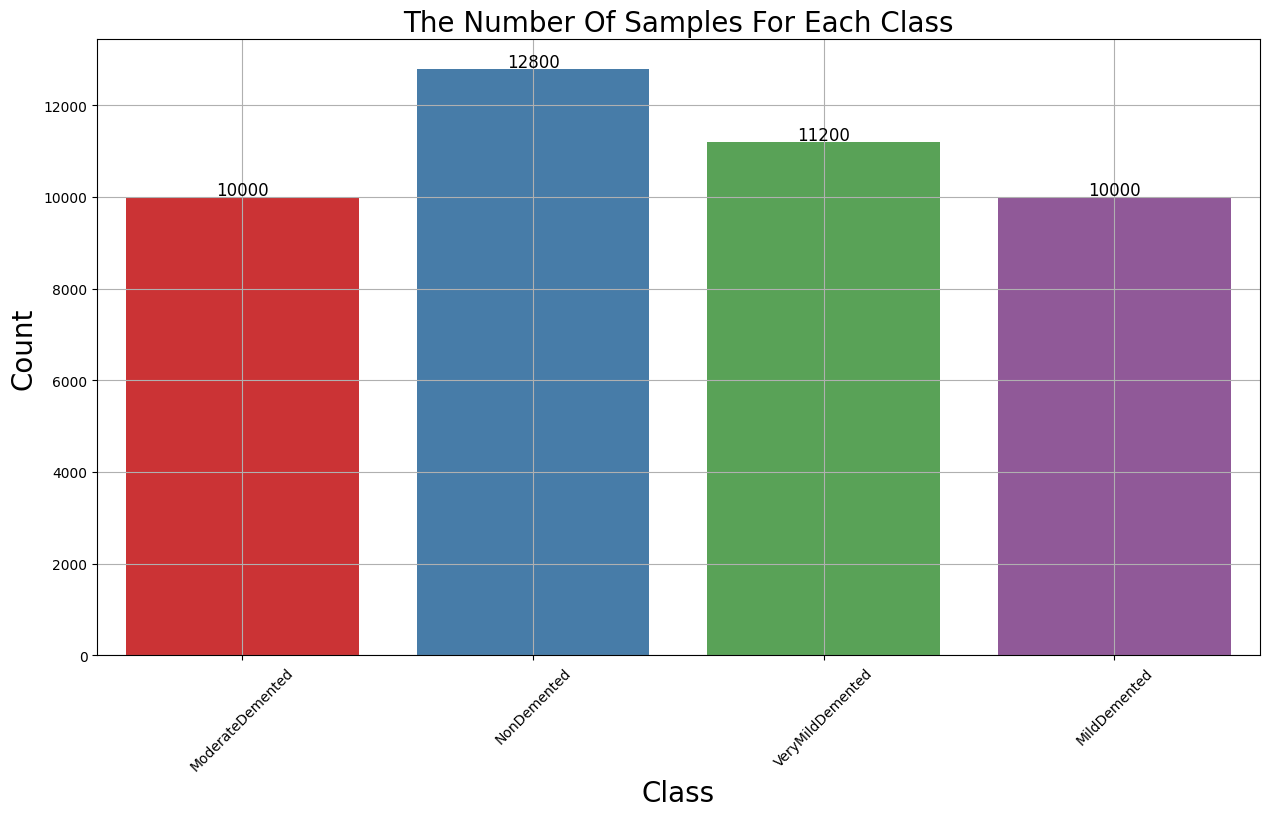

In [3]:
# Assuming `df` is your DataFrame and `label` is the column with class labels
class_counts = df['label'].value_counts()

# Print exact counts
print("Exact counts for each class:")
print(class_counts)

# Plot the class distribution
plt.figure(figsize=(15, 8))
ax = sns.countplot(x=df['label'], palette='Set1')
ax.set_xlabel("Class", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.title('The Number Of Samples For Each Class', fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)

# Annotate each bar with the exact count
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

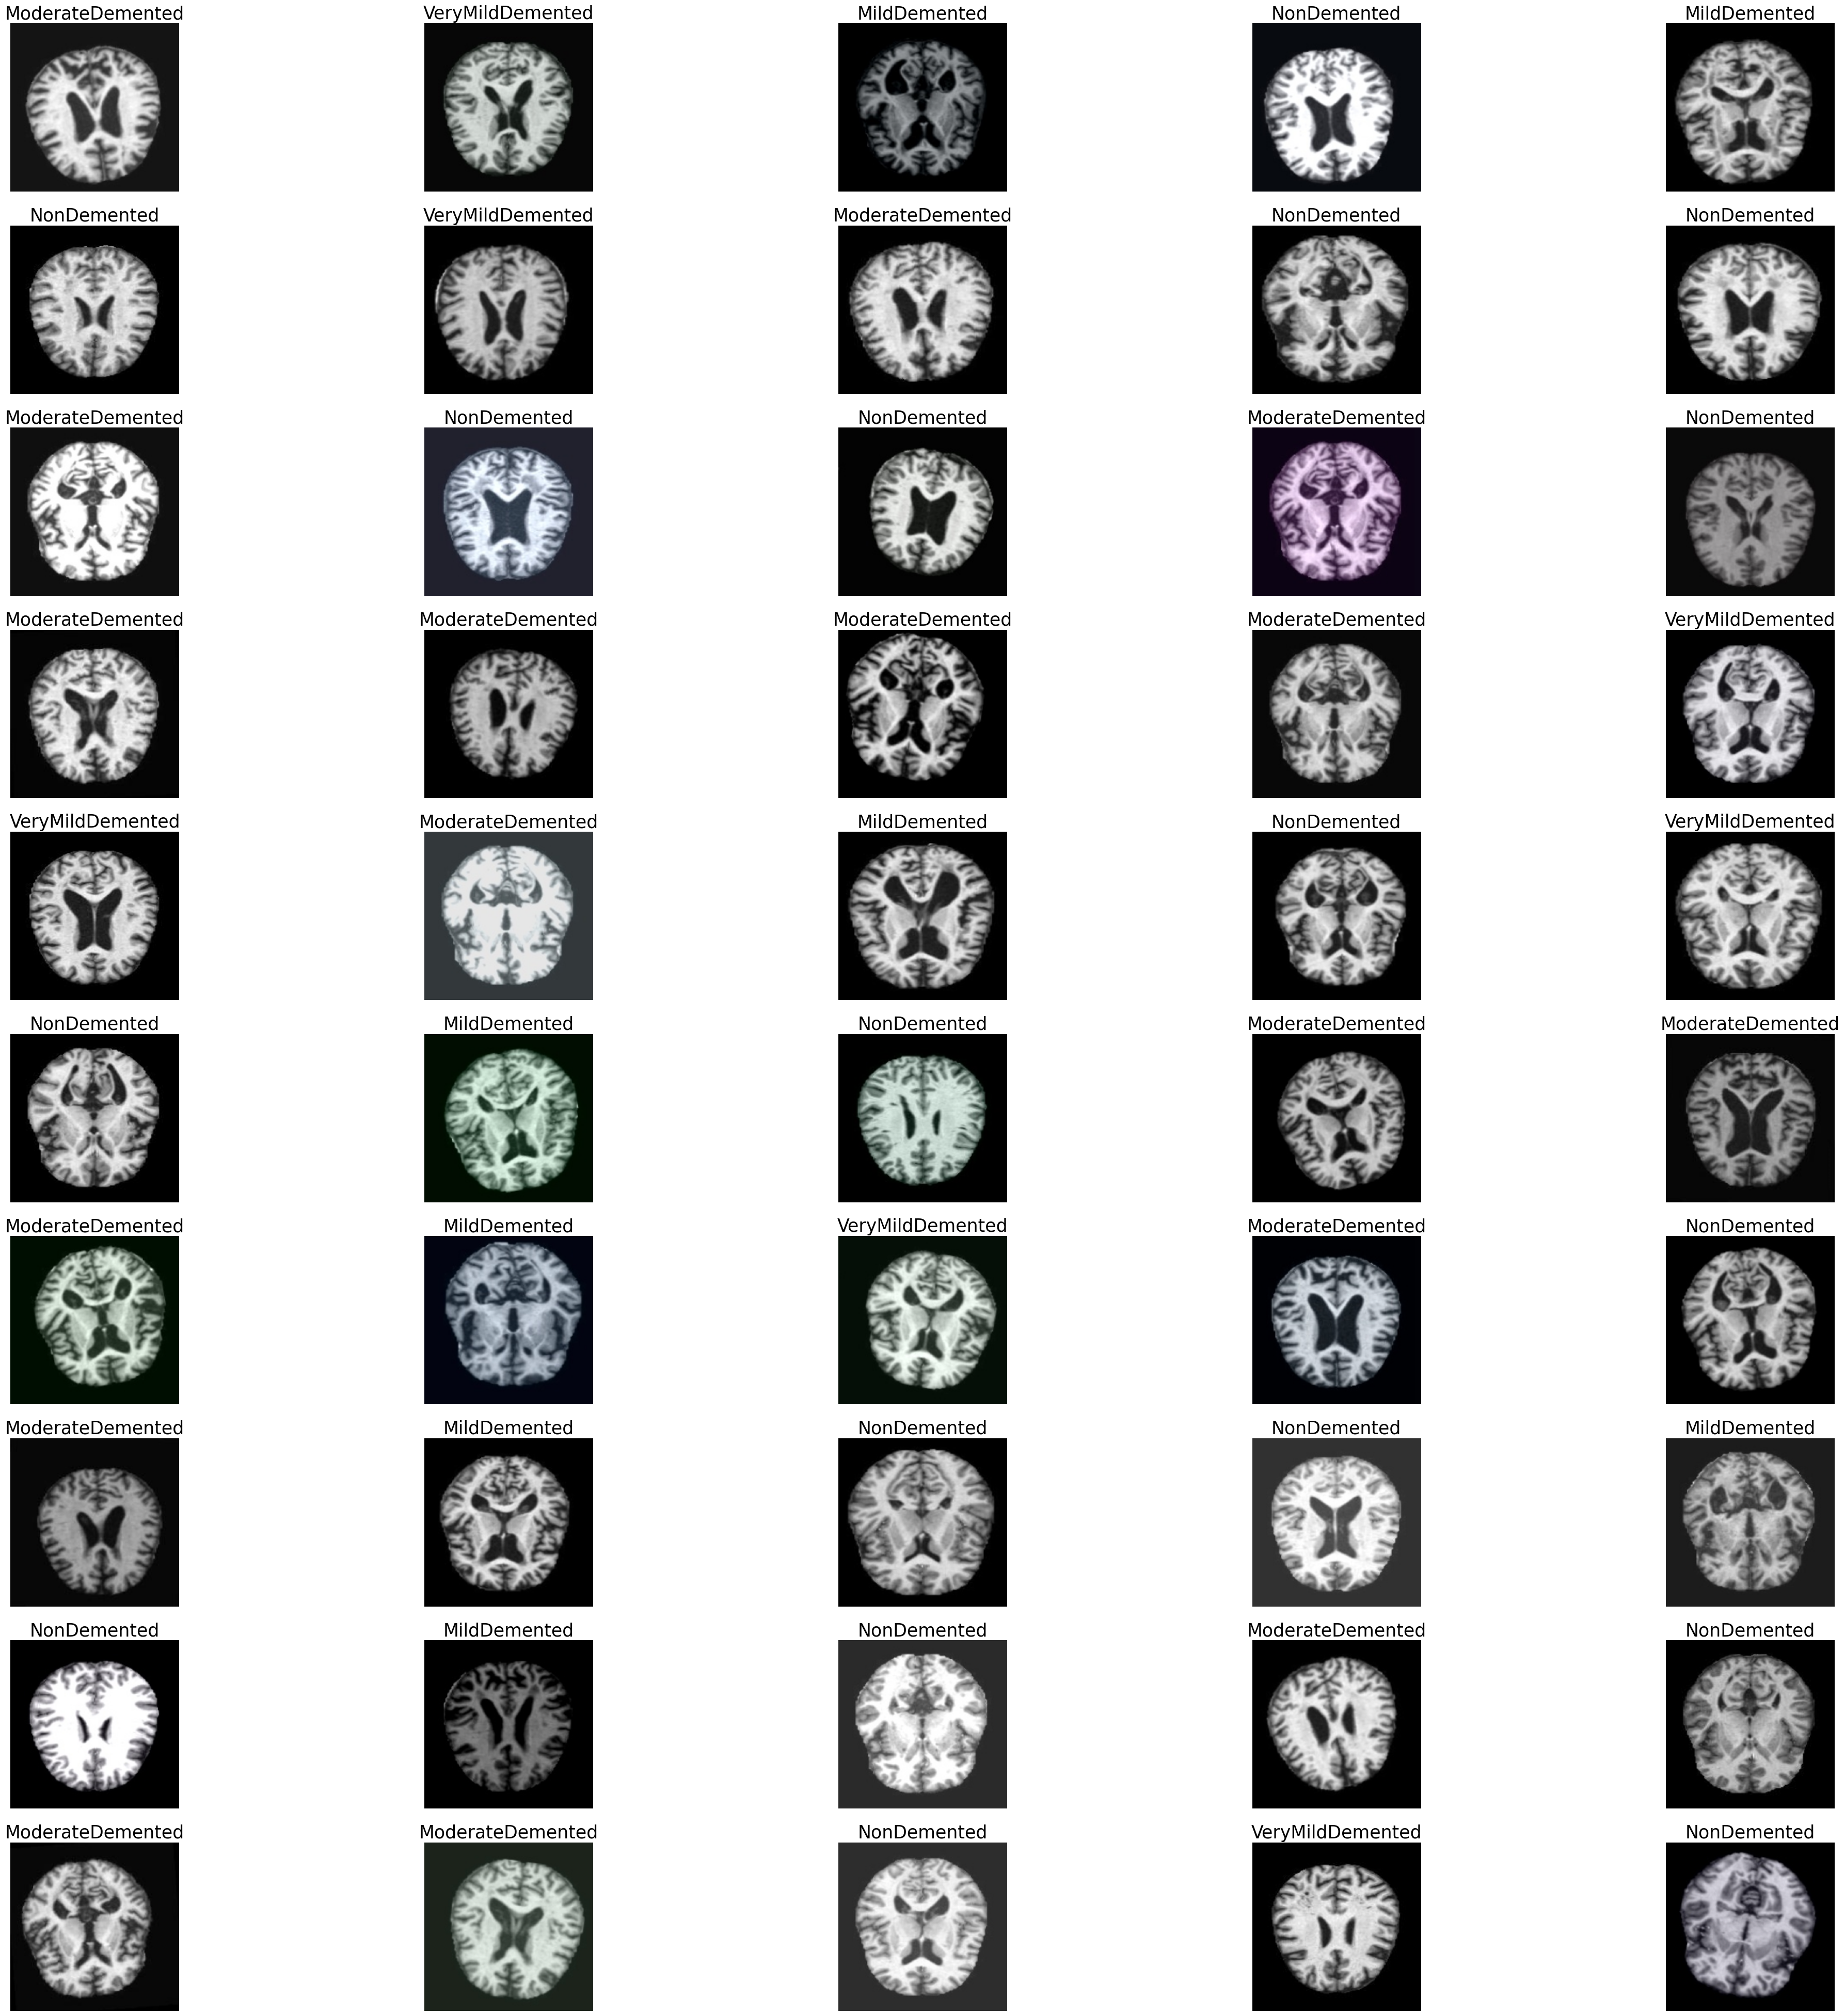

In [4]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

In [5]:
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42,shuffle=True,stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [6]:
image_size = (224,224)
batch_size = 32
datagen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet.preprocess_input,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 35200 validated image filenames belonging to 4 classes.
Found 4400 validated image filenames belonging to 4 classes.
Found 4400 validated image filenames belonging to 4 classes.


In [7]:
class_num=list(train_generator.class_indices.keys())
class_num

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [8]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential()
model.add(tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights='imagenet'))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(4, activation='softmax'))
model.layers[0].trainable = False

# Build the model with the correct input shape
model.build(input_shape=(None, 224, 224, 3))
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,881,924 (68.21 MB)

 Trainable params: 3,160,068 (12.05 MB)

 Non-trainable params: 14,721,856 (56.16 MB)

In [9]:
checkpoint_cb = ModelCheckpoint("model_VGG16.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1100/1100 ━━━━━━━━━━━━━━━━━━━━ 207s 173ms/step - accuracy: 0.7017 - loss: 0.9076 - val_accuracy: 0.8777 - val_loss: 0.3086
Epoch 2/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 182s 165ms/step - accuracy: 0.8676 - loss: 0.3358 - val_accuracy: 0.9189 - val_loss: 0.2158
Epoch 3/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 183s 166ms/step - accuracy: 0.9085 - loss: 0.2378 - val_accuracy: 0.9325 - val_loss: 0.1717
Epoch 4/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 190s 172ms/step - accuracy: 0.9313 - loss: 0.1820 - val_accuracy: 0.9500 - val_loss: 0.1356
Epoch 5/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 185s 167ms/step - accuracy: 0.9440 - loss: 0.1496 - val_accuracy: 0.9495 - val_loss: 0.1484
Epoch 6/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 183s 166ms/step - accuracy: 0.9543 - loss: 0.1223 - val_accuracy: 0.9430 - val_loss: 0.1774
Epoch 7/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 185s 168ms/step - accuracy: 0.9608 - loss: 0.1120 - val_accuracy: 0.9668 - val_loss: 0.1002
Epoch 8/50
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 185s 167ms/step - accuracy: 0.9

In [10]:
model.save('/kaggle/working/model_VGG16.keras')
model.export('/kaggle/working/model_VGG16')

Saved artifact at '/kaggle/working/model_VGG16'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_20')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  136629719550256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136629853820832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136629844316528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136629703960432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136629703964480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136629703960784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136629703963424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136629703964304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136629703962192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136629701333888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  

In [11]:
import os
print(os.listdir('/kaggle/working'))

['model_VGG16.keras', '__notebook__.ipynb', 'model_VGG16']


In [12]:
hist_=pd.DataFrame(hist.history)
hist_

accuracy      loss  val_accuracy  val_loss
0   0.765511  0.618330      0.877727  0.308635
1   0.877614  0.314290      0.918864  0.215834
2   0.911165  0.231255      0.932500  0.171714
3   0.929176  0.186877      0.950000  0.135603
4   0.943977  0.149157      0.949545  0.148388
5   0.952869  0.127819      0.942955  0.177445
6   0.958097  0.115463      0.966818  0.100160
7   0.962074  0.103095      0.959091  0.110347
8   0.967273  0.092617      0.963864  0.108427
9   0.971392  0.079762      0.974545  0.078133
10  0.974006  0.073122      0.967955  0.108956
11  0.975256  0.071155      0.977273  0.075753
12  0.978437  0.062824      0.969545  0.094531
13  0.979205  0.060404      0.974091  0.083050
14  0.979034  0.058816      0.976818  0.078681
15  0.983097  0.049755      0.971818  0.095898
16  0.982699  0.049464      0.975000  0.086727
17  0.984233  0.044937      0.978636  0.075454
18  0.984773  0.043713      0.977727  0.077476
19  0.985881  0.041598      0.977955  0.074346
20  0.985398  0.040867      0.983182  0.062919
21  0.986790  0.037936      0.979091  0.083943
22  0.987926  0.036027      0.977955  0.069871
23  0.987869  0.036427      0.981364  0.067581
24  0.988466  0.034974      0.978864  0.069197
25  0.987301  0.037939      0.978864  0.067276
26  0.990199  0.029468      0.983409  0.062877
27  0.990653  0.027980      0.977273  0.096602
28  0.988352  0.034028      0.981136  0.066103
29  0.990625  0.028217      0.982273  0.063790
30  0.991534  0.026990      0.981136  0.068825
31  0.991307  0.025458      0.979318  0.077801
32  0.990341  0.027593      0.980227  0.081389
33  0.991932  0.024970      0.982045  0.081712
34  0.990625  0.026985      0.978182  0.092632
35  0.991591  0.025770      0.985682  0.058529
36  0.993381  0.019369      0.985455  0.072558
37  0.991023  0.028101      0.980455  0.084716
38  0.992017  0.023743      0.982045  0.074730
39  0.992983  0.021507      0.985000  0.058063
40  0.992301  0.024407      0.980000  0.081415
41  0.993693  0.019093      0.984545  0.069822
42  0.992869  0.021414      0.986818  0.068514
43  0.993295  0.019423      0.984091  0.064183
44  0.992614  0.021643      0.985455  0.065456
45  0.993693  0.020801      0.988182  0.059115
46  0.993750  0.017652      0.985909  0.082429
47  0.993125  0.020202      0.986818  0.054599
48  0.994091  0.017175      0.985000  0.072307
49  0.993722  0.018841      0.984773  0.081518

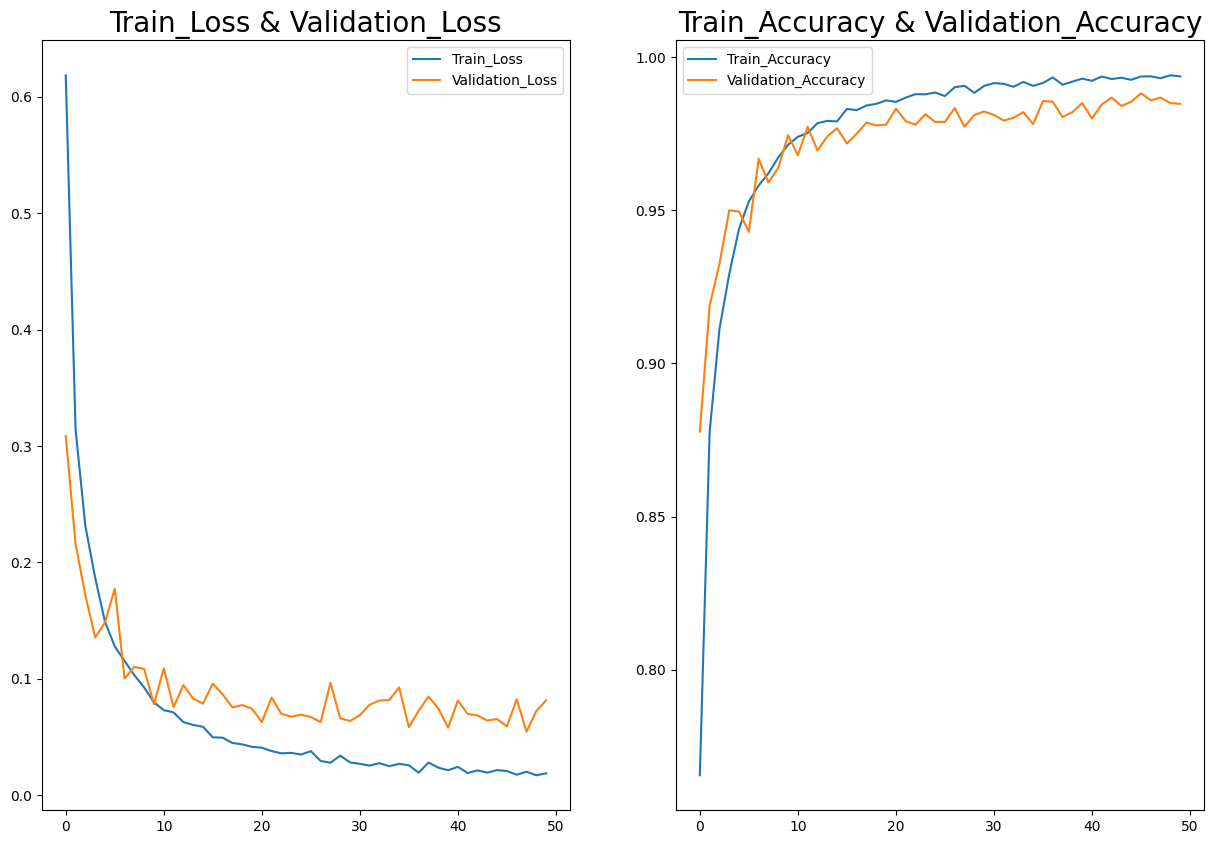

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [14]:
score, acc= model.evaluate(test_generator)
print('Val Loss =', score)
print('Val Accuracy =', acc)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


138/138 ━━━━━━━━━━━━━━━━━━━━ 24s 174ms/step - accuracy: 0.9888 - loss: 0.0490
Val Loss = 0.05781155079603195
Val Accuracy = 0.9877272844314575


In [15]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

138/138 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step


Actual  Prediction
0          0           0
1          3           3
2          1           1
3          1           1
4          2           2
...      ...         ...
4395       2           2
4396       3           3
4397       3           3
4398       0           0
4399       1           1

[4400 rows x 2 columns]

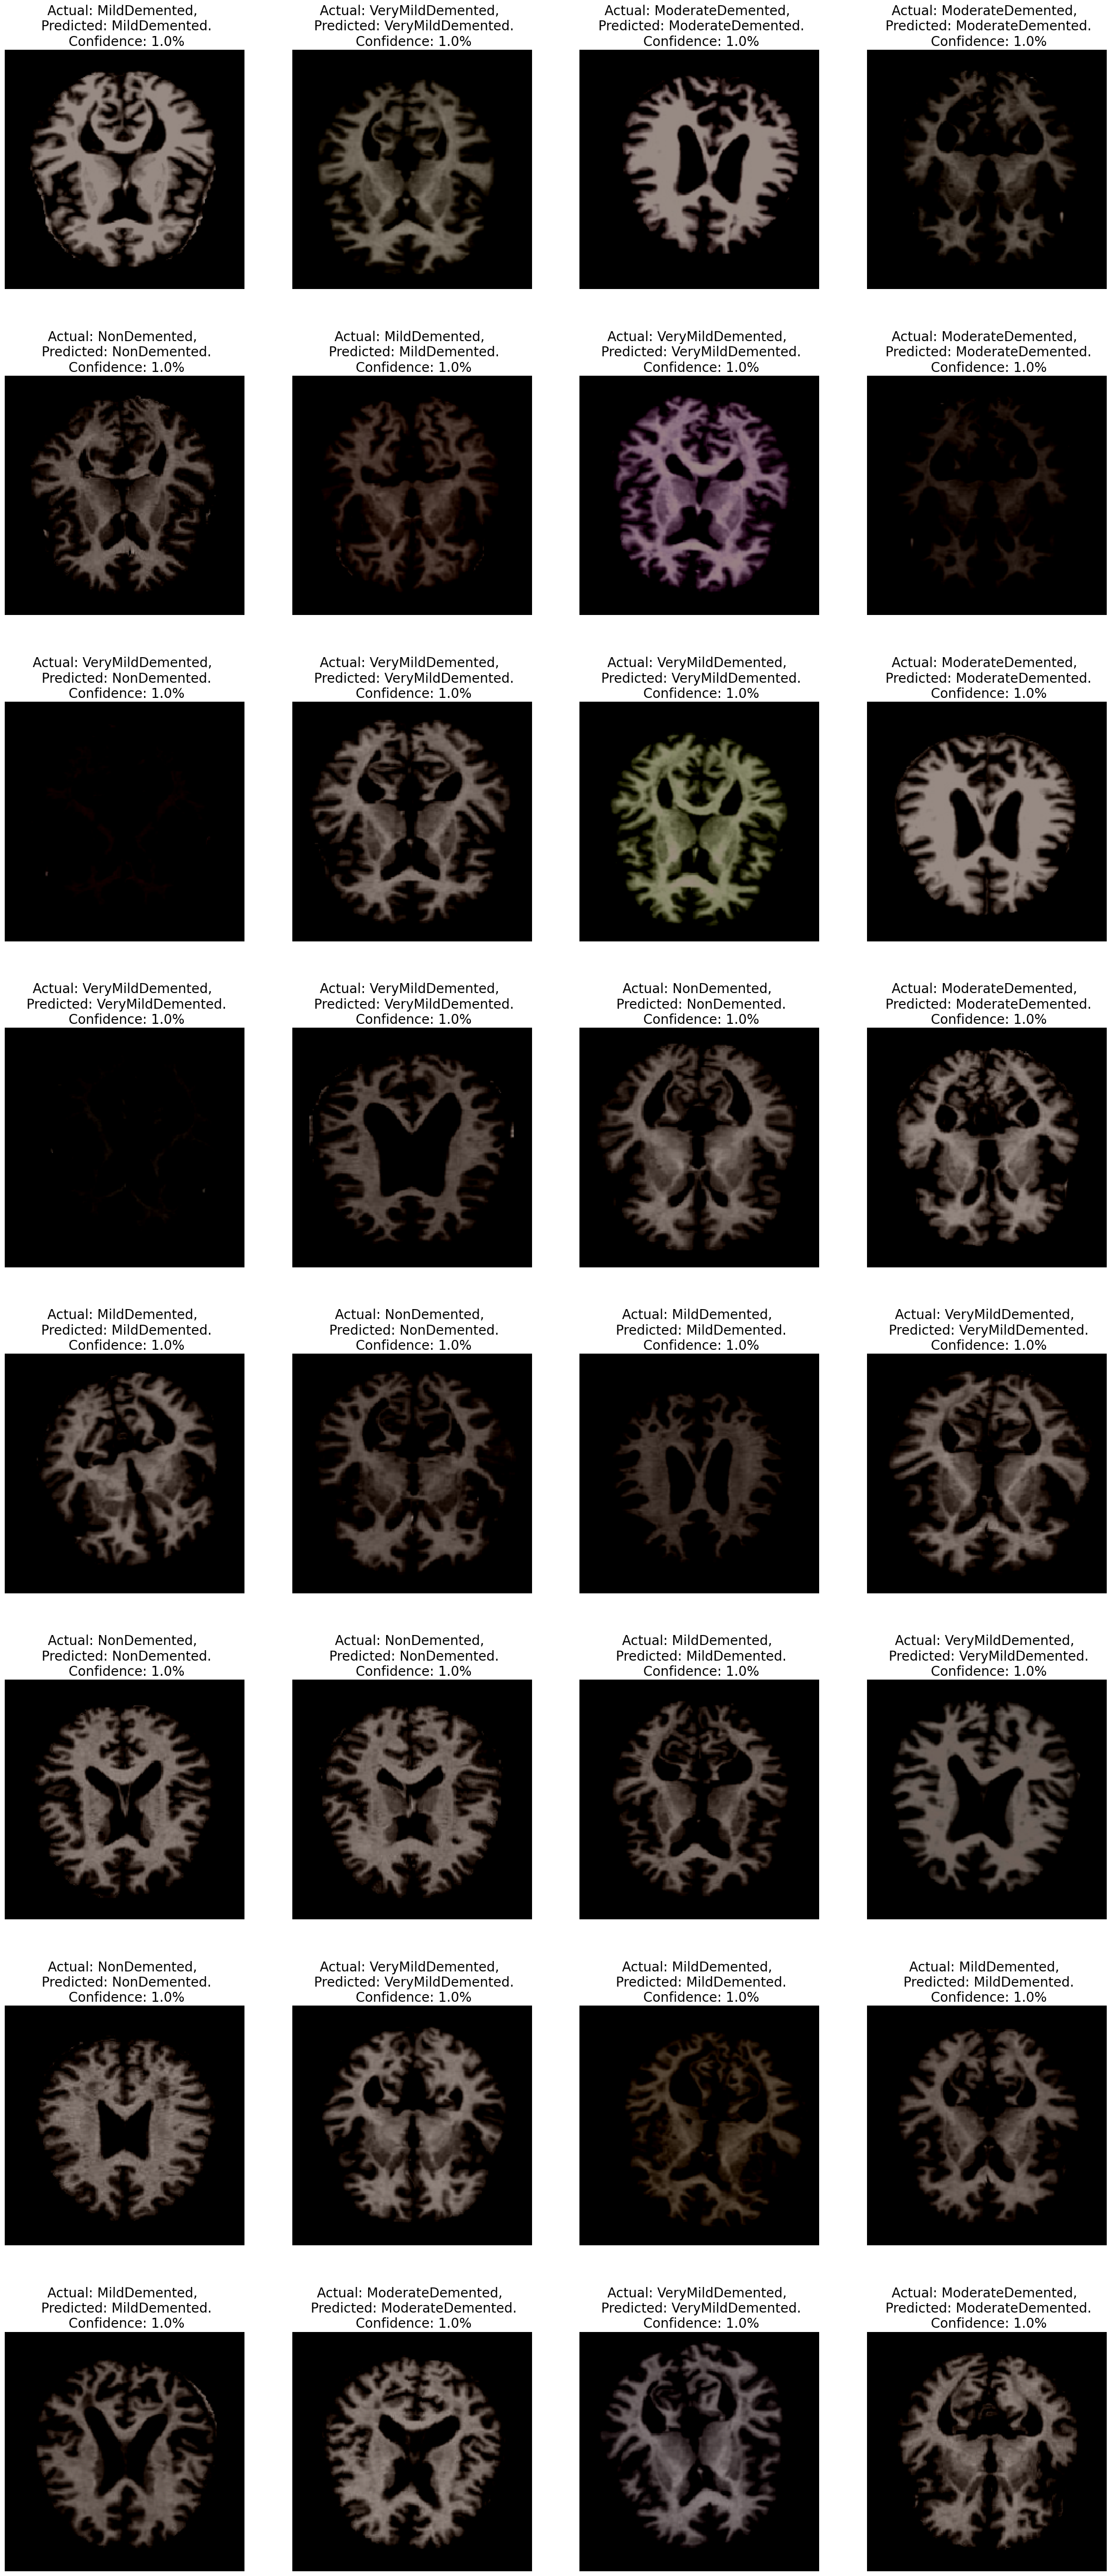

In [16]:
plt.figure(figsize=(30,70))
batch = next(test_generator)
images= batch[0]
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(f"Actual: {class_num[y_test[n]]}, \n Predicted: {class_num[y_pred[n]]}.\n Confidence: {round(predictions[n][np.argmax(predictions[n])],0)}%",fontsize=20)

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


array([[ 991,    1,    3,    5],
       [   0, 1000,    0,    0],
       [   8,    1, 1261,   10],
       [   5,    2,   16, 1097]])

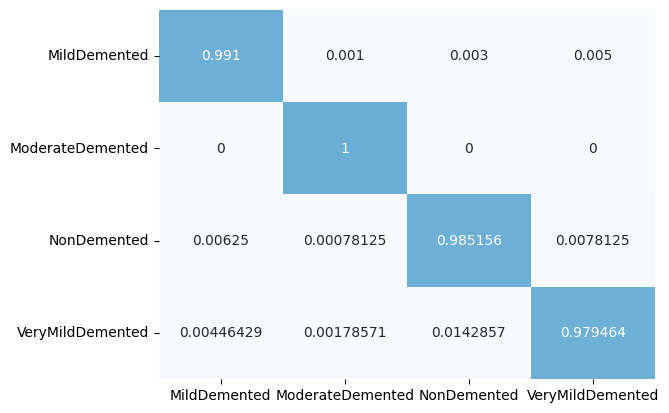

In [17]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues',xticklabels=class_num, yticklabels=class_num)
CM

In [18]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_num)
print('Classification Report is : ', ClassificationReport)

Classification Report is :                    precision    recall  f1-score   support

    MildDemented       0.99      0.99      0.99      1000
ModerateDemented       1.00      1.00      1.00      1000
     NonDemented       0.99      0.99      0.99      1280
VeryMildDemented       0.99      0.98      0.98      1120

        accuracy                           0.99      4400
       macro avg       0.99      0.99      0.99      4400
    weighted avg       0.99      0.99      0.99      4400



In [19]:
class_num=list(train_generator.class_indices.keys())
class_num

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


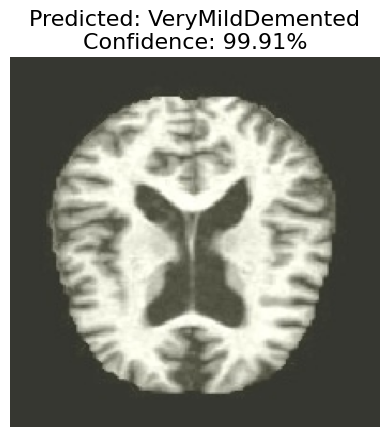

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

def predict_single_image(model, image_path, class_num, target_size=(224, 224)):
    """
    Predicts the class of a single image and displays it with the prediction and confidence.
    
    Args:
        model: Trained Keras model.
        image_path (str): Path to the image file.
        class_num (dict): Dictionary mapping class indices to class labels.
        target_size (tuple): Target size for resizing the image.
    """
    # Load and preprocess the image
    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image)  # Convert to numpy array
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    image_array = image_array / 255.0  # Normalize
    
    # Predict
    predictions = model.predict(image_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = class_num[predicted_class_index]
    confidence = round(np.max(predictions) * 100, 2)
    
    # Display the image and prediction
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class_label}\nConfidence: {confidence}%", fontsize=16)
    plt.show()

# Example Usage
image_path = "/kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented/combined_images/VeryMildDemented/0073c8fe-469d-4160-9344-37d61ac6f9bd.jpg"
class_num = {0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}
predict_single_image(model, image_path, class_num)
